## NY Stock Price Prediction RNN LSTM GRU
- This notebook demonstrates the future price prediction for different stocks using recurrent neural networks in tensorflow.
- Recurrent neural networks with basic, LSTM or GRU cells are implemented.

### 1. Setup

In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# split data in 80%/10%/10% train/validation/test sets
valid_percentage = 10 
test_percentage = 10 

#display parent directory and working directory
print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
print(os.getcwd()+':', os.listdir(os.getcwd()));

C:\Users\DI: ['.android', '.bash_history', '.cisco', '.conda', '.config', '.esg', '.git', '.gitconfig', '.ipynb_checkpoints', '.ipython', '.jupyter', '.keras', '.matplotlib', '.octave_hist', '.openjfx', '.popsql.json', '.python_history', '.sambox.cache', '.spyder', '.viminfo', '3D Objects', 'Anaconda2', 'anaconda3', 'AppData', 'Application Data', 'atm623', 'cartopy', 'cmip6hack-precip', 'config.xlaunch', 'Cookies', 'Desktop', 'Documents', 'Downloads', 'Evernote', 'Favorites', 'IntelGraphicsProfiles', 'Links', 'Local Settings', 'MicrosoftEdgeBackups', 'ML_playground', 'Music', 'My Documents', 'ncar-python-tutorial', 'NetHood', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{a0d63882-d2ce-11e9-8ad3-9b10e46cac19}.TM.blf', 'NTUSER.DAT{a0d63882-d2ce-11e9-8ad3-9b10e46cac19}.TMContainer00000000000000000001.regtrans-ms', 'NTUSER.DAT{a0d63882-d2ce-11e9-8ad3-9b10e46cac19}.TMContainer00000000000000000002.regtrans-ms', 'ntuser.ini', 'ODBA', 'OneDrive', 'Pictures', 'playground', 'Pr

### 2. Load & get first glimpse of data

In [2]:
# import all stock prices 
df = pd.read_csv("./nystock_data/prices-split-adjusted.csv", index_col = 0)
df.info()

# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])

#df.tail()  # df.head()
#df.describe()
# 2010-01-04 to 2016-12-30, nearly five years of daily stock price for 501 stocks

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB

number of different stocks:  501
['V', 'GE', 'NSC', 'PX', 'DLTR', 'AIV', 'ADBE', 'AYI', 'UHS', 'AMAT']


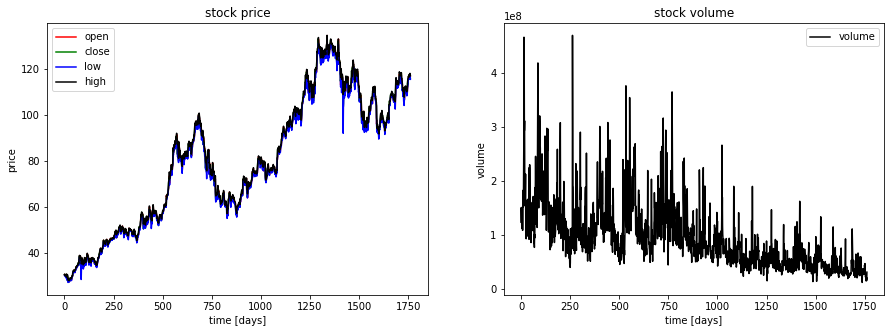

In [3]:
# visualize data
stk_name = 'AAPL'   # choose one stock

plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == stk_name].open.values, color='red', label='open')
plt.plot(df[df.symbol == stk_name].close.values, color='green', label='close')
plt.plot(df[df.symbol == stk_name].low.values, color='blue', label='low')
plt.plot(df[df.symbol == stk_name].high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.symbol == stk_name].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');


### 3. Data manipulation
- drop feature: volume
- normalize stock data
- create train, validation and test data sets

In [4]:
### function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

### function to create train, validation, test data given stock data and sequence length
def split_data(stock, seq_len):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create the predictor, timestep = seq_len, we need to use data[n-seq_len:n-1] to predict data[n]    
      # e.g., original data shape: (n,m); predictor shape (n, seq_len-1, m)
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    # split into train, valid, test
    data = np.array(data);
    valid_set_size = int(np.round(valid_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

### choose one stock, drop features
df_stock = df[df.symbol == stk_name].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)
  # check reamining features
cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

### normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)
# after normalization, the normalized values not reflect the <>= relationship in absolute values 

df_stock.columns.values =  ['open', 'close', 'low', 'high']


In [5]:
### create train, test data
timestep = 20 # specify timestep length
x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(df_stock_norm, timestep)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1394, 19, 4)
y_train.shape =  (1394, 4)
x_valid.shape =  (174, 19, 4)
y_valid.shape =  (174, 4)
x_test.shape =  (174, 19, 4)
y_test.shape =  (174, 4)


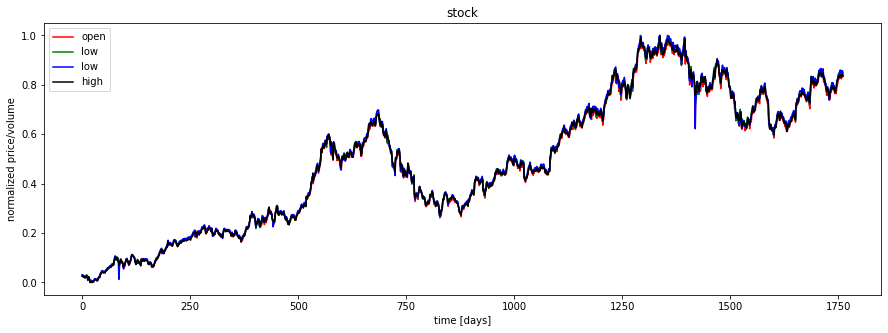

In [6]:
# visualize normalized data 
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

### 4. Employ RNN to model data
- RNN
- LSTM
- LSTM peephole
- GRU

In [ ]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

#tf.reset_default_graph()

X = tf.keras.Input(shape=(None, n_steps, n_inputs), dtype=tf.dtypes.float32)
y = tf.keras.Input(shape=(None, n_outputs), dtype=tf.dtypes.float32)

# use Basic RNN Cell
layers = [tf.keras.layers.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.keras.layers.StackedRNNCells(layers)
rnn_outputs, states = tf.keras.layers.RNN(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.keras.layers.Dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.math.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test}) 

In [7]:
# Specify model parameters:
#   - Sequential type, LSTM cell, # of neuron, optimizer, learning rate... 

n_neuron = 128
learning_rate = 0.001

model = keras.Sequential()
#model.add(keras.Input(shape=(timestep-1, n_inputs), dtype=tf.dtypes.float32))
model.add(keras.layers.GRU(
  units=n_neuron,
  input_shape=(x_train.shape[1],x_train.shape[2])
))
model.add(keras.layers.Dense(units=4))
model.compile(
  loss='mean_squared_error',                          # loss function = mean squared error
  optimizer=keras.optimizers.Adam(learning_rate)      # use Adam optimizer
)

In [8]:
# train the model
# !!! most important thing: NOT shuffle data, order is important

#n_steps = seq_len-1 
n_inputs = 4 
n_outputs = 4
n_layers = 2
batch_s = 30
n_epochs = 50 

history = model.fit(
    x_train, y_train,
    epochs=n_epochs,
    batch_size=batch_s,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/50
42/42 [==============================] - 4s 106ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 2/50
42/42 [==============================] - 3s 73ms/step - loss: 0.0064 - val_loss: 0.0014
Epoch 3/50
42/42 [==============================] - 2s 48ms/step - loss: 0.0017 - val_loss: 6.3301e-04
Epoch 4/50
42/42 [==============================] - 1s 33ms/step - loss: 6.2831e-04 - val_loss: 4.9664e-04
Epoch 5/50
42/42 [==============================] - 1s 26ms/step - loss: 3.6059e-04 - val_loss: 4.9010e-04
Epoch 6/50
42/42 [==============================] - 1s 27ms/step - loss: 2.5824e-04 - val_loss: 4.2683e-04
Epoch 7/50
42/42 [==============================] - 2s 49ms/step - loss: 2.0363e-04 - val_loss: 3.4447e-04
Epoch 8/50
42/42 [==============================] - 3s 78ms/step - loss: 1.8036e-04 - val_loss: 3.1195e-04
Epoch 9/50
42/42 [==============================] - 3s 79ms/step - loss: 1.7799e-04 - val_loss: 3.1466e-04
Epoch 10/50
42/42 [==============================] - 3s 

In [9]:
# Evaluation
y_pred = model.predict(x_test)

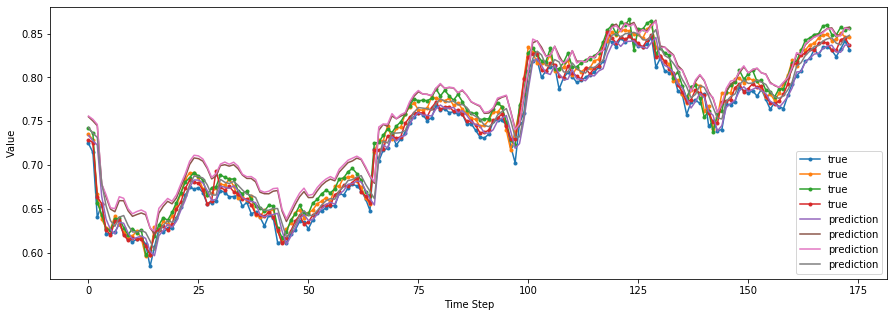

In [10]:
plt.figure(figsize=(15, 5));
plt.plot(y_test, marker='.',label="true")
plt.plot(y_pred,  label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()